# This notebook has 2 tasks:
## 1. Explore association between critical genes and neurological diseases
## 2. Explore coexpression between critical genes and DEGs

In [1]:
from opentargets import OpenTargetsClient
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sys import platform 
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'

# Load critical gene lists (with subselection method)

In [2]:
critical_gene_path = prefix + '/Shared drives/NIAAA_ASSIST/Data/feature_extraction_derived/'
critical_gene_dfs = []
embedding_names = []
for file in os.listdir(critical_gene_path):
    if file.startswith('module') and file.endswith('.csv'):
        df = pd.read_csv(critical_gene_path + '/' + file)
        critical_gene_dfs.append(df)
        embedding_names.append('_'.join(file.split('_')[:3]))

In [3]:
client = OpenTargetsClient()
response = client.filter_associations()

C:\Users\bbche\miniconda3\lib\site-packages\opentargets\conn.py:299: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.api_specs = yaml.load(self.swagger_yaml)


In [13]:
cg_lists1 = []
for i in range(5):
    cg_lists1 += [gene for gene in critical_gene_dfs[i]['gene'][:20]]

In [14]:
neuro_dict1 = {}
for gene in cg_lists1:
    cnt = 0
    response.filter(target = gene, scorevalue_min = 0.7)
    for r in response:
        if ('nervous' in r['disease']['efo_info']['label'].lower()) or ('neuro' in r['disease']['efo_info']['label'].lower()):
            cnt += 1
    if cnt > 0:
        gene = r['target']['gene_info']['symbol']
        neuro_dict1[gene] = cnt

In [166]:
len(neuro_dict1)

22

In [4]:
from collections import OrderedDict
def plot_target_disease(disease_dict):
    plt.figure(figsize = (len(disease_dict)/3.5,4))
    sorted_dict = dict(sorted(disease_dict.items(), key = lambda x:x[1], reverse=True))
    plt.bar(sorted_dict.keys(), sorted_dict.values())
    plt.xticks(rotation = 45, ha = 'right')
    plt.ylabel('# associated neuro diseases')
    plt.title('Open target search')

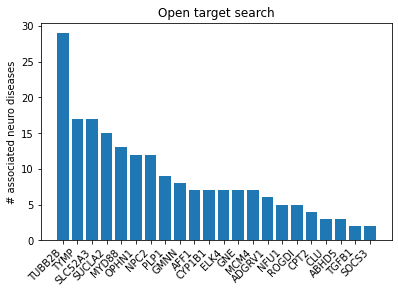

In [164]:
plot_target_disease(neuro_dict1)

# Load critical gene list (with whole network embedding method)

In [15]:
critical_gene_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/feature_extraction_derived/epoch=100_alpha=0.1_critical_gene_df.csv')

In [16]:
neuro_dict2 = {}
cg_list2 = critical_gene_df['gene'][:100]
for gene in cg_list2:
    cnt = 0
    response.filter(target = gene, scorevalue_min = 0.7)
    for r in response:
        if ('nervous' in r['disease']['efo_info']['label'].lower()) or ('neuro' in r['disease']['efo_info']['label'].lower()):
            cnt += 1
    if cnt > 0:
        gene = r['target']['gene_info']['symbol']
        neuro_dict2[gene] = cnt

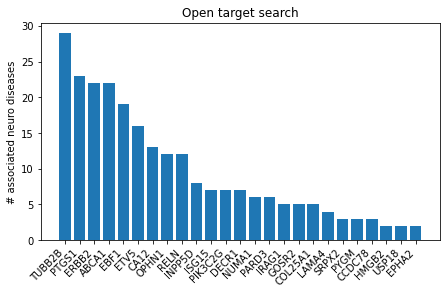

In [165]:
plot_target_disease(neuro_dict2)

# Search Open Target with DEGs

In [5]:
deseq = pd.read_excel(r'G:\Shared drives\NIAAA_ASSIST\Data\deseq.alc.vs.control.age.rin.batch.gender.PMI.corrected.w.prot.coding.gene.name.xlsx')

In [7]:
deseq['abs_log2FC'] = abs(deseq['log2FoldChange'])
deseq.sort_values('abs_log2FC', ascending = False, inplace = True)

In [9]:
neuro_dict3 = {}
cg_list3 = deseq['id'][:100]
for gene in cg_list3:
    cnt = 0
    response.filter(target = gene, scorevalue_min = 0.7)
    for r in response:
        if ('nervous' in r['disease']['efo_info']['label'].lower()) or ('neuro' in r['disease']['efo_info']['label'].lower()):
            cnt += 1
    if cnt > 0:
        gene = r['target']['gene_info']['symbol']
        neuro_dict3[gene] = cnt

In [106]:
for k in neuro_dict2:
    print(k)
for k in neuro_dict3:
    print(k)

ERBB2
ABCA1
HMGB2
LAMA4
ISG15
ETV5
USP18
IRAG1
OPHN1
RELN
GOSR2
NUMA1
PIK3C2G
CA12
EBF1
INPP5D
SRPX2
COL25A1
PARD3
PYGM
PTGS1
EPHA2
DECR1
CCDC78
TUBB2B
TRPC3
PIK3C2G
FREM1
CXCL12
SRPX2
PROM1
SDC4
HMCN1
ERBB2
CACNA1S
EDN3
CA12
TAL1
HMGB2
BAG3
CCND1
PTPRQ
LIPC
LUM
RELN
OTOGL
ELN
SELP
KCNK10
PYGM
EMCN
RLBP1
VEGFC
CDHR1
TFCP2L1
APOC1
PDK4
STON2


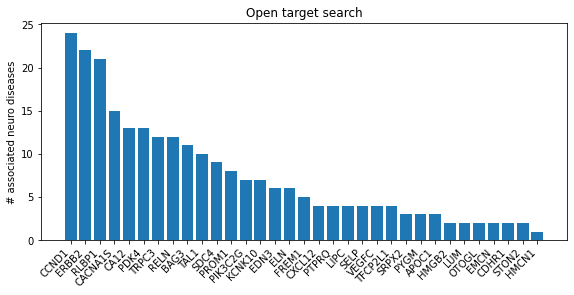

In [10]:
plot_target_disease(neuro_dict3)

# Use GeneNetwork2 (http://gn2.genenetwork.org/) to find the expression data and perform correlation analysis

In [275]:
def plot_corr_data(gtex_data, deg_list, cg_list):
    gtex_clean = gtex_data.loc[20:].replace('x', np.NaN)
    corr_df = gtex_clean.iloc[:,1:].apply(pd.to_numeric).corr()
    deg_cols = corr_df.columns[corr_df.columns.isin(deg_list)]
    cg_cols = corr_df.columns[corr_df.columns.isin(cg_list)]
    relevant_corr = corr_df[cg_cols].loc[deg_cols] # get only the cg columns and deg rows 
#     sort_corr1 = relevant_corr[relevant_corr.mean().sort_values().index] # sort columns by column mean
#     sort_corr2 = sort_corr1.reindex(sort_corr1.mean(axis = 1).sort_values().index) # sort index by index mean
    plt.rcParams.update({'font.size':14})
    plt.figure(figsize = (14, 11))
    g = sns.clustermap(relevant_corr, cmap = 'RdBu_r', vmin = -1, vmax = 1)
    g.ax_heatmap.set_xlabel('Critical genes')
    g.ax_heatmap.set_ylabel('DEGs')
    plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=45, ha = 'right')
    return relevant_corr

In [230]:
deg_list = deseq['id'][:50]
cg_list = cg_list2[:50]

In [231]:
with open(f'../../data/genes_to_search.txt', 'w') as file:
    for gene in deg_list:
        file.writelines(f'{gene}\n')
    for gene in cg_list:
        file.writelines(f'{gene}\n')

In [236]:
gtex_v8 = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\GTEx_v8_traits.csv', skiprows = 12)

In [244]:
gene_dict = {gtex_v8.columns[i]:gtex_v8.loc[0][i] for i in range(1, len(gtex_v8.columns))}

In [253]:
gtex_v8.columns = gtex_v8.loc[0]
gtex_v8 = gtex_v8.iloc[1:,:]

In [247]:
deg_list_convert = list(map(gene_dict.get, deg_list))
cg_list_convert = list(map(gene_dict.get, cg_list))

<Figure size 1008x792 with 0 Axes>

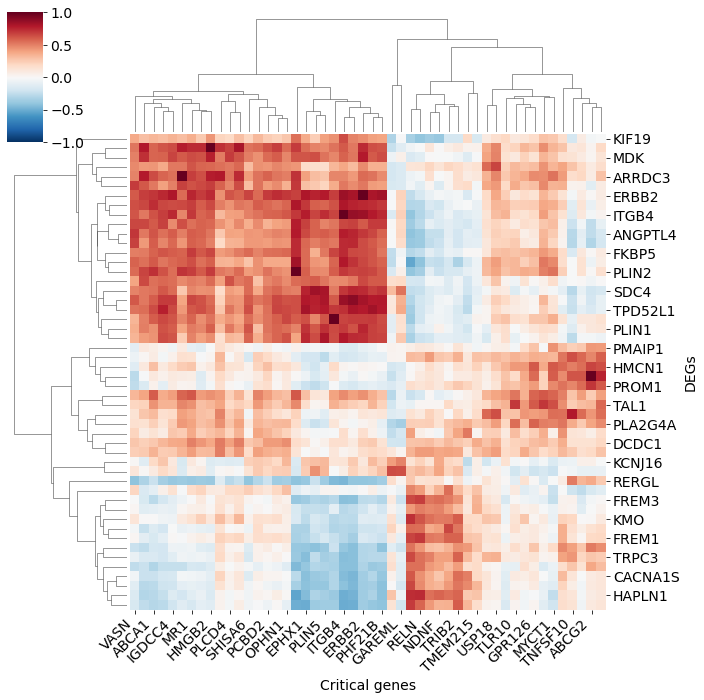

In [276]:
sorted_corr_df = plot_corr_data(gtex_v8, deg_list_convert, cg_list_convert)

In [264]:
print('average |corr| is:',np.mean(abs(sorted_corr_df).mean()))

average |corr| is: 0.294310930177876


## Get random 25 genes from deseq and determine how much correlation there is between DEGs and Critical genes

In [263]:
deg_list = deseq['id'][:50]
random_cg = deseq['id'].sample(50)
with open(f'../../data/random_genes_to_search.txt', 'w') as file:
    for gene in deg_list:
        file.writelines(f'{gene}\n')
    for gene in random_cg:
        file.writelines(f'{gene}\n')

In [265]:
gtex_v8_random = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\GTEx_v8_traits_random.csv', skiprows = 12)

In [266]:
gene_dict2 = {gtex_v8_random.columns[i]:gtex_v8_random.loc[0][i] for i in range(1, len(gtex_v8_random.columns))}

In [268]:
gtex_v8_random.columns = gtex_v8_random.loc[0]
gtex_v8_random = gtex_v8_random.iloc[1:,:]

In [269]:
deg_list_convert2 = list(map(gene_dict2.get, deg_list))
cg_list_convert2 = list(map(gene_dict2.get, random_cg))

<Figure size 1008x792 with 0 Axes>

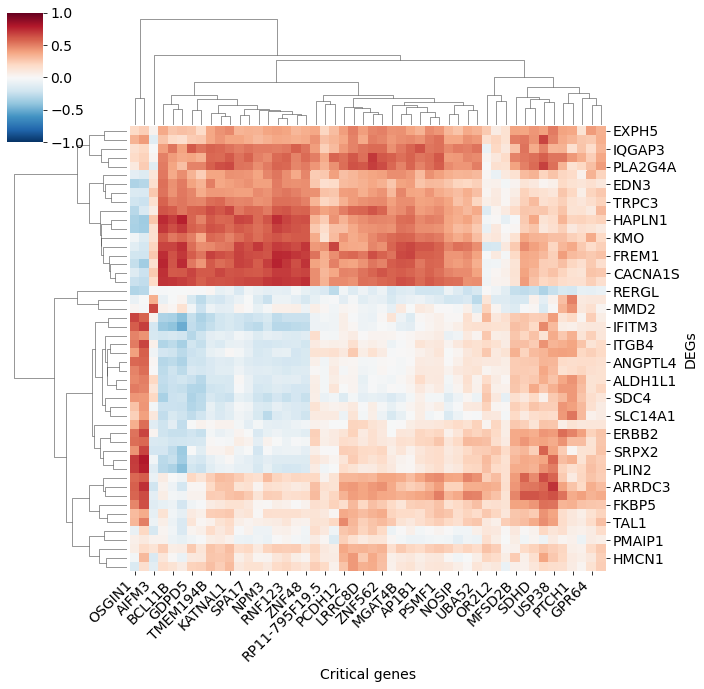

In [277]:
sorted_corr_df2 = plot_corr_data(gtex_v8_random, deg_list_convert2, cg_list_convert2)

In [273]:
print('average |corr| is:',np.mean(abs(sorted_corr_df2).mean()))

average |corr| is: 0.25944795681131905
